### Анализ текстов джазовых песен

**Описание**:

В качестве материала для анализа мы решили взять песни четырех "классических" исполнителей музыки в жанре "джаз": Фрэнка Синатры, Дина Мартина, Нэта Кинг Коула и Луи Армстронга. Мы взяли по пятьдесят наиболее знаменитых и популярных песен каждого из композиторов (в случае Нэта Кинг Коула вышло только шестнадцать) для анализа по таким параметрам, как продолжительность и наиболее часто используемые слова.

В качестве инструментов для парсинга текста был использован модуль lyricsgenius, продолжительность вытащена с Youtube.

In [1]:
!pip install -r requirements.txt
!python -m spacy download en_core_web_sm
import json
import lyricsgenius
import re
import time
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from lyricsgenius import Genius
from spacy.lang.en.stop_words import STOP_WORDS
from collections import defaultdict
from nltk import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer

# Загрузка данных

В данном разделе выполните выгрузку данных из внешних источников и их локальное сохранение

Вы можете вынести всю логику выгрузки в отдельный `.py` скрипт (или набор скриптов), поместив их в директорию `scripts` в корне проекта, но продублируйте весь код здесь тоже, чтобы можно было запустить ноутбук с самого начала

In [3]:
# Облегченный метод, позволяющий пропустить ошибки api при генерации очищенного текста. Скачивает final_lyrics,
#успешный прогнанный через все скрипты без ошибок.
df = pd.read_csv('data/final_lyrics')
#начальная предобработка
df['lyrics_clean'] = df['lyrics'].replace(r'[^\w\s]',' ',regex=True).replace(r'\s+',' ',regex=True).str.lower()

In [11]:
# Оригинальный код через скрипт. Время от времени api выдает ошибку.

def clean_genius_lyrics(text):
    # Удаляем все технические блоки перед текстом песни
    text = re.sub(
        r'^(\d+\s*Contributors|.*?Lyrics\b).*?\n',
        '',
        text,
        flags=re.IGNORECASE | re.DOTALL | re.MULTILINE
    )

    # Удаляем Read More и всё до него
    text = re.split(r'Read More\s*\n', text, flags=re.IGNORECASE)[-1]

    # Дополнительные паттерны
    patterns = [
        r'Genius Annotation.*',
        r'You might also like.*',
        r'Embed\s*\d+',
        r'\xa0',
        r'^[\W\d_]+$'  # Удаляем строки из спецсимволов/чисел
    ]

    for pattern in patterns:
        text = re.sub(pattern, '', text, flags=re.IGNORECASE | re.DOTALL)

    # Финальная очистка
    text = "\n".join([line.strip() for line in text.split("\n") if line.strip()])
    return text.strip()
with open(".venv/config.json") as f:
    config = json.load(f)

genius = lyricsgenius.Genius(config["genius_token"])
genius.remove_section_headers = True
artists = ['Frank Sinatra', 'Dean Martin', 'Nat "King" Cole', 'Louis Armstrong']

all_songs = []

for artist in artists:
    try:
        if artist != 'Nat "King" Cole':
            artist_obj = genius.search_artist(artist, max_songs = 50, sort='popularity')
            for song in artist_obj.songs:
                all_songs.append({
                    'artist': song.artist,
                    'title': song.title,
                    'lyrics': clean_genius_lyrics(song.lyrics)
            })
        else:
            artist_obj = genius.search_artist(artist, max_songs=16, sort='popularity')
            for song in artist_obj.songs:
                all_songs.append({
                    'artist': song.artist,
                    'title': song.title,
                    'lyrics': clean_genius_lyrics(song.lyrics)
                })
    except:
        print(f'Ошибка для {artist}')

lyrics = pd.DataFrame(all_songs)
lyrics = lyrics.drop_duplicates(subset=['artist', 'title', 'lyrics'])
lyrics_csv = lyrics.to_csv('lyrics_all.csv',sep=',', index= False )

# Получаем продолжительность

with open(".venv/config.json") as f:
    config = json.load(f)

lyrics = pd.read_csv('lyrics_all.csv')
def get_youtube_duration(artist, title):
    try:
        results = YoutubeSearch(f"{artist} {title}", max_results=1).to_dict()
        return results[0]["duration"]
    except:
        return None

lyrics["duration"] = lyrics.apply(lambda row: get_youtube_duration(row["artist"], row["title"]), axis=1)
def convert_duration(duration):
    minutes = int(duration)
    seconds = round((duration - minutes) * 100)  # Извлекаем две цифры после точки
    return (minutes * 60)  + seconds

# Применяем функцию к колонке duration
lyrics["duration"] = lyrics["duration"].apply(convert_duration)

# Сохраняем результат в новый файл
lyrics.to_csv("lyr_dur1_sec.csv", index=False)

# Получаем год выпуска треков и финализируем файл.

with open(".venv/config.json") as f:
    config = json.load(f)
DISCOGS_TOKEN = config["discogs_token"]


def get_discogs_year(artist, title):
    url = f"https://api.discogs.com/database/search?q={artist}+{title}&type=release"
    headers = {"Authorization": f"Discogs token={DISCOGS_TOKEN}"}

    try:
        response = requests.get(url, headers=headers)
        data = response.json()
        return data["results"][0]["year"] if data["results"] else None
    except:
        return None

lyrics = pd.read_csv("lyr_dur1_sec.csv")
lyrics["year"] = lyrics.apply(lambda row: get_discogs_year(row["artist"], row["title"]), axis=1)

final_lyrics = lyrics.to_csv('final_lyrics', index=False)

Searching for songs by Frank Sinatra...

Song 1: "Fly Me to the Moon"
Song 2: "My Way"
Song 3: "That’s Life"
Song 4: "Theme from New York, New York"
Song 5: "The Girl From Ipanema (Garota De Ipanema)"
Song 6: "Have Yourself a Merry Little Christmas"
Song 7: "Somethin’ Stupid"
Song 8: "It Was a Very Good Year"
Song 9: "The Way You Look Tonight"
Song 10: "My Funny Valentine"
Song 11: "I’ve Got You Under My Skin"
Song 12: "Come Fly with Me (Platinum Version)"
Song 13: "Blue Moon"
Song 14: "Strangers in the Night"
Song 15: "Let It Snow! Let It Snow! Let It Snow!"
Song 16: "Luck Be a Lady"
Song 17: "High Hopes"
Song 18: "The Best Is Yet to Come"
Song 19: "Autumn Leaves"
Song 20: "I’m a Fool to Want You"
Song 21: "The Lady Is a Tramp"
Song 22: "You Make Me Feel So Young"
Song 23: "Jingle Bells"
Song 24: "It Had to Be You"
Song 25: "Quiet Nights of Quiet Stars (Corcovado)"
Song 26: "In the Wee Small Hours of the Morning"
Song 27: "Summer Wind"
Song 28: "All the Way"
Song 29: "Witchcraft"
Song

TypeError: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'

## Очистка данных и подготовка к анализу

В данном разделе выполните все шаги, связанные с предобработкой:
- приведение ваших данных к формату датафрейма (если это не было сделано выше)
- разведочный анализ (EDA)

Exploratory Data Analysis (EDA) - важный этап анализа данных, помогающий понять, с чем мы вообще имеем дело. [Пример выполнения разведанализа](https://www.kaggle.com/code/imoore/intro-to-exploratory-data-analysis-eda-in-python). Не копируйте все функции в лоб - на что именно стоит смотреть зависит от вашего исследования, однако точно стоит посмотреть на:
- какие переменные (колонки) вообще есть
- каких они типов
- есть ли пропуски
- как переменные распределены (если в этом есть смысл). Для по крайней мере начального анализа распределений и/или трендов в данных, возможно, есть смысл построить визуализации

---

Если хотите, можете попробовать вот [эту библиотеку](https://docs.profiling.ydata.ai/latest/) (полезна для EDA), но огромная просьба - не вставляйте куски кода с ней в конечный отчёт, ибо запуска процесса профилирования может быть довольно долгим, а на больших датасетах это может приводить к довольно тяжелым ноутбукам. Если будете использовать вышеупомянутый `ydata-profiling`, делайте это в отдельном ноутбуке (назовите его `EDA.ipynb`), а в этом постарайтесь обойтись без него

In [ ]:
# Загрузим модель для английского языка
nlp = spacy.load("en_core_web_sm")
custom_stop_words = ["gobble", "bidee", "ve", "ll", "oh", "ya", "ain", "don", "didn", "te",
"fasule", "tay", "ce", "la", "em", "di", "il", "er", "de", "to", "ba", "da", "doo", "zee", "boo", "mmm"]

# Добавим кастомные слова к стоп-словам
STOP_WORDS.update(custom_stop_words)

def lemmatize_text(text):
    doc = nlp(text)
    lemmas = []
    for token in doc:
        if not token.is_stop and token.is_alpha and len(token) > 1:
            lemmas.append(token.lemma_)
    return lemmas

# Применим лемматизацию к предобработанному столбцу с текстами песен
df['lemmatized'] = df['lyrics_clean'].apply(lemmatize_text)

## Анализ и визуализация

Весь мыслительный процесс, связанный с аналитикой ваших данных, а также построения визуализаций поместите в данный раздел

In [7]:
# Собираем все слова из колонки 'lemmatized'
all_words = [word for row in df['lemmatized'] for word in row]

# Обрабатываем текст через spaCy
doc = nlp(" ".join(all_words))

# Создаем распределение по частям речи
pos_distribution = defaultdict(list)

for token in doc:
    pos = token.pos_  # Универсальные теги (NOUN, VERB, ADJ, ADV и т.д.)
    pos_distribution[pos].append(token.text)

# Упрощаем теги
simplified_mapping = {
    "NOUN": "noun",
    "VERB": "verb",
    "ADJ": "adj",
    "ADV": "adv",
    # Остальные категории объединяем в 'other'
}

simplified_distribution = defaultdict(list)
for pos, words in pos_distribution.items():
    simplified_pos = simplified_mapping.get(pos, "other")
    simplified_distribution[simplified_pos].extend(words)


In [8]:
# Топ 20 существительных
top_noun = FreqDist(simplified_distribution['noun']).most_common(20)
print(top_noun)
# Топ 20 глаголов
top_verb = FreqDist(simplified_distribution['verb']).most_common(20)
print(top_verb)
# Топ 20 прилагательных
top_adj = FreqDist(simplified_distribution['adj']).most_common(20)
print(top_adj)
# Топ 20 наречий
top_adv = FreqDist(simplified_distribution['adv']).most_common(20)
print(top_adv)

[('love', 208), ('way', 98), ('heart', 89), ('dream', 83), ('day', 69), ('time', 68), ('life', 61), ('world', 58), ('baby', 52), ('night', 48), ('thing', 47), ('snow', 46), ('boom', 40), ('spook', 40), ('wheel', 39), ('home', 36), ('people', 34), ('eye', 34), ('air', 34), ('song', 32)]
[('let', 125), ('go', 117), ('get', 109), ('know', 80), ('come', 76), ('find', 60), ('say', 50), ('hear', 44), ('sing', 43), ('see', 39), ('tell', 39), ('look', 37), ('think', 36), ('feel', 35), ('leave', 31), ('love', 28), ('fly', 26), ('hold', 24), ('fall', 24), ('make', 23)]
[('good', 61), ('old', 52), ('sweet', 43), ('dear', 40), ('little', 38), ('funny', 27), ('long', 26), ('young', 26), ('blue', 26), ('wonderful', 26), ('middle', 25), ('true', 24), ('big', 22), ('happy', 22), ('warm', 19), ('open', 18), ('bright', 18), ('lovely', 16), ('low', 14), ('cold', 14)]
[('away', 46), ('long', 27), ('right', 23), ('someday', 19), ('way', 15), ('far', 12), ('soon', 12), ('pretty', 11), ('forever', 8), ('well

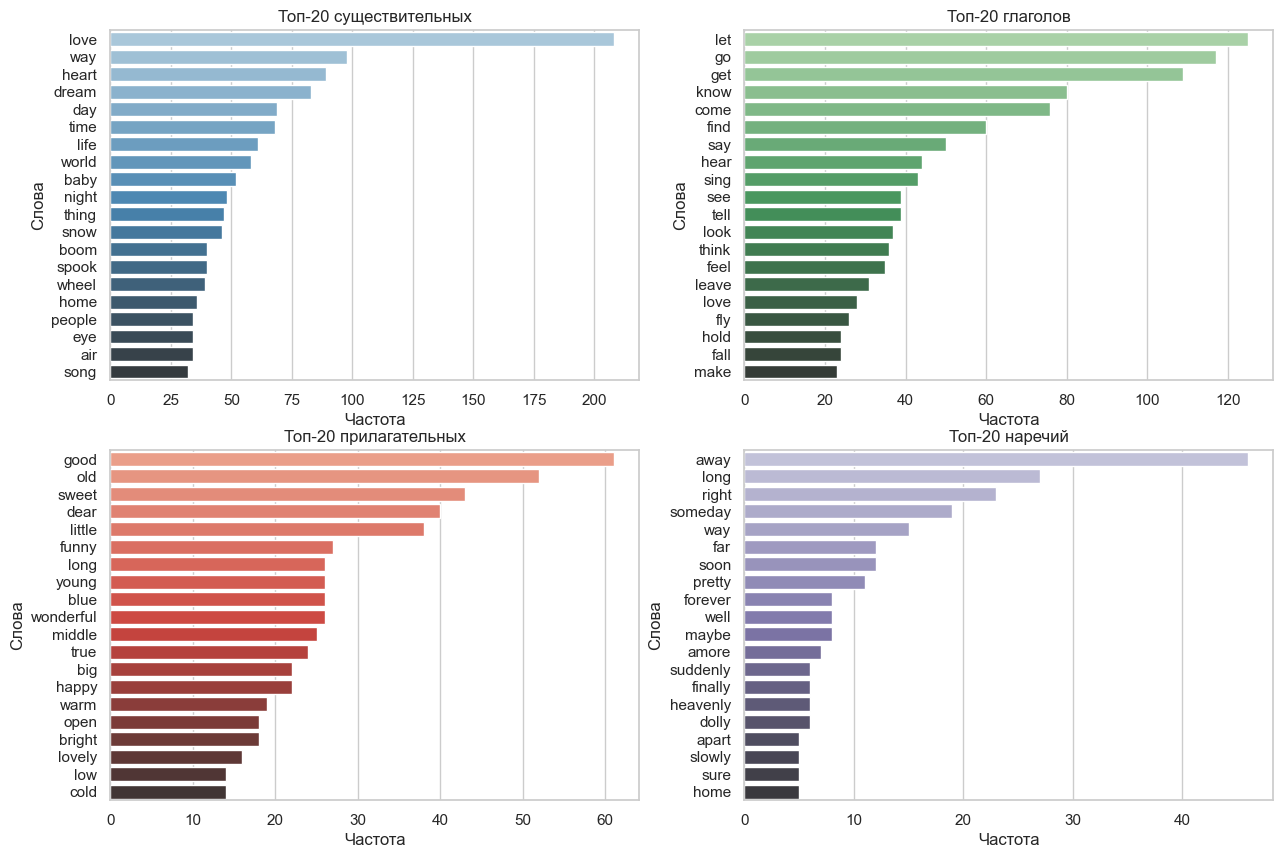

In [9]:
# Настройка стиля
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 10))

# Функция для построения графиков
def plot_top_words(data, title, palette, position):
    plt.subplot(2, 2, position)
    words, counts = zip(*data)
    sns.barplot(
        x=list(counts),
        y=list(words),
        hue=list(words),
        palette=palette,
        legend=False
    )
    plt.title(title)
    plt.xlabel("Частота")
    plt.ylabel('Слова')

# Построение графиков
plot_top_words(top_noun, "Топ-20 существительных", "Blues_d", 1)
plot_top_words(top_verb, "Топ-20 глаголов", "Greens_d", 2)
plot_top_words(top_adj, "Топ-20 прилагательных", "Reds_d", 3)
plot_top_words(top_adv, "Топ-20 наречий", "Purples_d", 4)

## Выводы 

Опишите в данном разделе, какие выводы вы можете сделать из вашей аналитики и визуализаций? (подробно)

**Анализ частоты слов**:

Чаще всего именно существительные являются центральными словами в песнях, поскольку именно существительные выступают темой и главным лейтмотивом тех или иных песен. Как ни странно и предсказуемо, именно любовь (Love) лидирует в топ-20 слов среди существительных. Будучи одной из главных тем песен любой эпохи, в эпоху джаза любовь остается самым распространенным словом - свыше 200 упоминаний среди существительных. Это также самое распространенное слово в джазовых песнях в целом.
**Однако!** Не стоит забывать про то, что love - также и глагол. Пускай это и не отменяет остальных наблюдений, даже так love имеет вдвое больше упоминаний, чем way, как второй глагол. Вместе с существительным вариантом, love является САМЫМ распространенным словом среди всех четырех топов.

Из прилагательных - стоит отметить, что почти все они, кроме двух (low, cold) имеют так или иначе положительный окрас. Наличие этих двоих слов в топе, учитывая их относительно небольшое количество (около 15 у каждого) может либо значить использование подобных слов в качестве контраста в песнях, либо то, что они встречаются лишь в небольшом количестве песен. В остальном, положительный окрас большинства прилагательных можно связать с двумя вещами: либо то, что как жанр, сам по себе джаз в основном поднимает темы с положительным окрасом, вроде любви, счастья, верности, и сами песни поэтому имеют положительный окрас. Либо это можно связать с социокультурным явлением послевоенной "золотой эпохи" и экономическим процветанием США. Закат эры свинга как музыкального жанра пришелся на первую половину сороковых, в то время как джаз захватил популярность и стал главным музыкальным жанром США как раз к второй половине сороковых и оставался таким вплоть до шестидесятых. 

В анализе глаголов стоит отметить глагол let - в то время, как сами поставленные нами условия это не нарушает, одной из двух пересекающихся песен, помимо Blue Moon, является Let it Snow с 25 упоминаниями глагола Let. Учитывая известность обоих вариантов этих песен, как и в случае с Blue Moon, для общего проекта это не является особо большой проблемой. В остальном глаголы и наречания не представляют особого интереса, и особо ничего не сообщают.

## Обсуждение

**Что мы хотели сделать в рамках нашего исследования и что сделать удалось**

Изначально нашим планом было проанализировать лишь три исполнителя, однако в процессе мы решили добавить четвертого (Луи Армстронга) для более широкой выборки. Это также позволило нам компенсировать тот факт, что у Нэта Кинг Коула лишь шестнадцать песен вместо пятидесяти, как у всех остальных. Можно считать, что самую основную часть работы (выяснение продолжительности песен, анализ наиболее часто встречаемых слов) мы выполнили на "отлично".
 
**Что не удалось сделать и почему**

Одной из главных визуализаций данных, которую мы планировали вставить, изначально был анализ наиболее значимых для этих музыкантов лет через подсчет песен по датам их выпуска и создания на этой основе графика. Проблема возникла с музыкальной базой данных и её api - из 166 треков 90 оказалось без дат. Следовательно, анализ данных получился бы по меньшей мере практически полностью недостоверным.  Мы также были вынуждены отказаться от полноценной визуализации с wordcloud в связи с некоторыми багами, из-за которых он мог цеплять целые словосочетания вместо одного слова. В один момент мы также рассматривали идею убрать дубликаты песен из подборки, однако в конечном счете решили, что это не имеет смысла относительно того, что именно мы анализируем. 

**Как наше исследование можно было бы улучшить**

Возможно, расширить выборку ещё на несколько знаменитых джазовых исполнителей: возможно, Пегги Ли, Бинга Кросби, Джона Колтрэйна, Билли Холидея, Сэмми Дэвиса. Если бы мы расширили выборку, из нишевого проекта это стало бы более значимой работой. Кроме того, вместо 50 наиболее знаменитых песен каждого музыканта мы могли взять всю их дискографию. Однако в таком случае также пришлось бы чистить подборку от возможных дубликатов некоторых песен, вроде Blue Moon. Из более экспериментальных идей - попробовать пошарить по американским сайтам в поисках данных о продажах копий джазовых альбомов Фрэнка Синатры, как одного из самых известных исполнителей джазовых песен (даже если и не джазмена в классическом понимании термина) и сопоставить с продажами рок-н-ролльных альбомов и синглов Элвиса Пресли, как самого известного исполнителя в жанре рок-н-ролла, дабы отследить момент, где джаз уступил рок-н-роллу в популярности среди простых обывателей.

Fun Fact: В нашем готовом датасете (пусть и сделанном на основе скрипта) песня "Blue Moon" встречается два раза. Изначально не написанная ни Синатрой, ни Дином Мартином, она была создана в тридцатых и исполнялась огромным количеством певцов и групп в самые разные времена. Её исполнял даже Элвис Пресли в самой начале своей карьеры, причем его звучание песни сильно отличается не только от более торжественных версий, но и от его более поздних работ.

**Кому наше исследование может быть полезно (или что можно сделать дополнительно, чтобы оно было полезным)**

Если провести изменения, которые мы описали в прошлом блоке по поводу улучшения нашего проекта, чисто теоретически, оно бы могло использоваться в полноценной научной работе по поводу джаза. Провести подобное с рок-н-роллом в тех же годах, а также с ещё парой доминирующих жанров, вроде диско и более классического рока/рэпа, и подобную таблицу можно было бы использовать в научной работе по поводу различных музыкальных эпох в США, и как одни жанры выходили из моды и заменялись другими с развитием культуры. В зависимости от типа исследования также может иметь смысл удаление дубликатов Blue Moon и Let it Snow.

В общем и целом, это исследование так и останется весьма специфичным и нишевым исследованием, однако базовая логика может быть улучшена и адаптирована и для более серьезных работ.